The point of this notebook is to make sure that the aggregation algorithm accurately aggregates the data.

For this notebook we'll assume that the data has already been grouped.

In [2]:
%pylab inline
import pandas as pd

%load_ext autoreload
%autoreload 2
import palm_diagnostics as pdiag

Populating the interactive namespace from numpy and matplotlib


/Users/david/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/david/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/david/Box Sync/Python/Scripts/palm_diagnostics.py:709: UserWarning: Calibration not available ...
  warnings.warn("Calibration not available ...")


In [3]:
# original code
def agg_groups(df_grouped):
    """Aggregate groups
    
    https://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_variance
    """
    coords = ["x", "y", "z"]
    
    # save the labels for weighted coords and weights
    w_coords = []
    w_coords2 = []
    weights = []
    
    # loop through coords generating weights and weighted coords
    for c in coords:
        # calculate weights
        s = "sigma_" + c
        df_grouped[s + "_inv"] = 1 / df_grouped[s] ** 2
        weights.append(s + "_inv")
        x = c + "0"
        # weighted position
        df_grouped[x + "_w"] = df_grouped[x].mul(df_grouped[s + "_inv"], "index")
        w_coords.append(x + "_w")
        # weighted position^2
        df_grouped[x + "_w2"] = (df_grouped[x]**2).mul(df_grouped[s + "_inv"], "index")
        w_coords2.append(x + "_w2")
    
    # groupby group_id and sum
    temp_gb = df_grouped.groupby("group_id")
    
    # calculate sum weights
    sum_w = temp_gb[weights].sum().values
    
    # finish weighted mean
    new_coords = temp_gb[w_coords].sum() / sum_w
    
    # doing this here to preserve order
    new_coords2_values = (new_coords**2)[w_coords].values
    new_coords.columns = [c.replace("_w", "") for c in new_coords.columns]
    
    # calc new sigma
    # basically the weighted std dev of the points added in quadrature to the 
    # std dev of the std dev of all points
    # $$
    # \sqrt{\frac{\sum w_i (x_i - \mu^*)^2}{\sum w_i} + \frac{1}{\sum w_i}} \\
    # \sqrt{\frac{\sum w_i x_i^2}{\sum w_i} - \mu^{*2} + \frac{1}{\sum w_i}} \\
    # \sqrt{\frac{\sum w_i x_i^2 + 1}{\sum w_i} - \mu^{*2}} \\
    # w_i = \frac{1}{\sigma_i^2}
    # $$
    new_sigmas = np.sqrt((temp_gb[w_coords2].sum() + 1) / sum_w -
                         new_coords2_values)
    new_sigmas.columns = ["sigma_" + c[0] for c in new_sigmas.columns]
    
    # calc new group params
    new_amp = temp_gb[["amp", "nphotons", "chi2"]].sum()
    new_frame = temp_gb[["frame"]].first()
    groupsize = temp_gb.x0.count()
    groupsize.name = "groupsize"
    
    # take the mean of all remaining columns
    # figure out columns to drop
    other_columns = ["groupsize"] + w_coords + w_coords2 + weights
    for df in (new_coords, new_sigmas, new_amp, new_frame):
        other_columns += df.columns.tolist()
    other_columns += ["group_id"]
    columns_to_mean = df_grouped.columns.difference(other_columns)
    # take the mean
    new_means = temp_gb[columns_to_mean].mean()
    
    # drop added columns from original data frame
    df_grouped.drop(columns=w_coords + weights + w_coords2, inplace=True)
    
    # return new data frame
    return pd.concat([new_coords, new_sigmas, new_amp, new_frame, groupsize, new_means], axis=1)

https://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_variance

calc new sigma
basically the weighted std dev of the points added in quadrature to the 
std dev of the std dev of all points
$$
\sqrt{\frac{\sum w_i (x_i - \mu^*)^2}{\sum w_i} + \frac{1}{\sum w_i}} \\
\sqrt{\frac{\sum w_i x_i^2}{\sum w_i} - \mu^{*2} + \frac{1}{\sum w_i}} \\
\sqrt{\frac{\sum w_i x_i^2 + 1}{\sum w_i} - \mu^{*2}} \\
w_i = \frac{1}{\sigma_i^2}
$$

However, this is **wrong** as I can demonstrate with a bootstrapping method

In [4]:
# generate data
columns = ["amp", "nphotons", "chi2", "frame", "offset"]

sigmas = ["sigma_" + c for c in "xyz"]
coords = [c + "0" for c in "xyz"]

num_localizations = 1000000

columns += coords + sigmas
# uniformly distributed data (space)
# data = np.random.rand(num_localizations, len(columns)) - 0.5
# normally distributed data (space)
data = np.random.randn(num_localizations, len(columns))
data = pd.DataFrame(data, columns=columns)
# split into 1000 random groups
# data["group_id"] = np.arange(len(data)) // 100
data["group_id"] = (np.random.randn(num_localizations) * 100).astype(int)
# data["group_id"] = np.random.randint(1000, size=num_localizations)

# equal weights
# data[sigmas] = 1
# non-equal weights
data[sigmas] = np.random.chisquare(300, size= (num_localizations, 3))
# this places coordinates according to their localization position
data[coords] *= data[sigmas].values
data.head()

,amp,nphotons,chi2,frame,offset,x0,y0,z0,sigma_x,sigma_y,sigma_z,group_id
0,-0.815115,-0.240666,-0.128225,0.565256,-0.390441,-1.536083,141.725931,354.338826,272.065691,257.477713,303.283515,-15
1,0.162581,0.884513,1.148160,-1.211142,-0.905156,225.533138,368.584127,400.710547,282.755224,333.886046,313.288884,137
2,-0.103889,-0.839069,-3.365347,-1.048462,-0.830134,-63.776512,287.119218,9.674894,288.310939,297.064028,254.020445,46
3,-0.758560,-0.536116,1.087045,0.147440,0.747870,-240.218627,111.078527,144.176235,315.401140,320.958086,288.876422,16
4,-0.517824,1.310672,0.109591,-1.039661,0.561962,-192.160246,-42.973841,-264.499936,294.486698,299.232029,334.627457,7


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x103bae4a8>]],
      dtype=object)

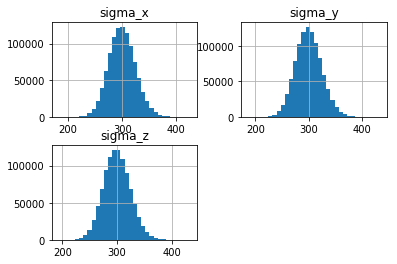

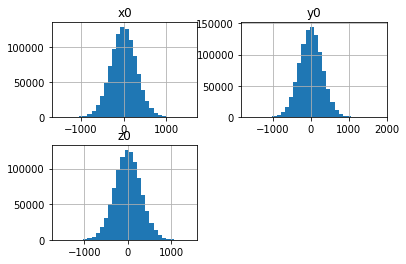

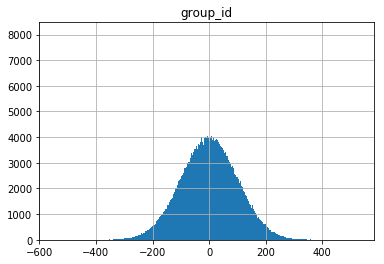

In [5]:
data[sigmas].hist(bins=32)
data[coords].hist(bins=32)
data[["group_id"]].hist(bins=np.arange(data.group_id.min(), data.group_id.max() + 1))

In [6]:
def weighted_mean(df):
    """Weighted mean as defined here https://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Statistical_properties"""
    if len(df) == 1:
        return df[coords]
    weights = 1 / df[sigmas].values ** 2
    new_coords = (df[coords].values * weights).sum(0, keepdims=True) / weights.sum(0)
    return pd.DataFrame(new_coords, columns=coords)

In [7]:
def weighted_variance(df):
    """https://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_variance
    
    Note that this is the estimated sample variance, **not** the variance of the mean"""
    if len(df) == 1:
        return df[sigmas]
    weights = 1 / df[sigmas].values ** 2
    V1 = weights.sum(0, keepdims=True)
    V2 = (weights ** 2).sum(0, keepdims=True)
    mu = weighted_mean(df)[coords].values
    xi = df[coords].values
    denominator = V1 - V2 / V1
    s = (weights * (xi - mu) ** 2).sum(0, keepdims=True) / denominator
    return pd.DataFrame(np.sqrt(s), columns=sigmas)

In [8]:
# There is no generally accepted formula for the standard error of the weighted mean
# However this paper https://www.cs.tufts.edu/~nr/cs257/archive/donald-gatz/weighted-standard-error.pdf
# tests a few proposed formulas, this is the one they claim works the best which we'll
# test in a boot strap method

def weighted_variance2(df):
    """https://www.cs.tufts.edu/~nr/cs257/archive/donald-gatz/weighted-standard-error.pdf"""
    if len(df) == 1:
        return df[sigmas]
    wi = 1 / df[sigmas].values ** 2
    V1 = wi.sum(0, keepdims=True)
    mu = weighted_mean(df)[coords].values
    xi = df[coords].values
    n = len(df)
    A = n / ((n-1) * V1 ** 2)
    a = (wi - V1)
    b = (wi * xi - V1 * mu)
    B = (b ** 2).sum(0, keepdims=True)
    C = 2 * mu * (a * b).sum(0, keepdims=True)
    D = (mu ** 2) * (a ** 2).sum(0, keepdims=True)
    s = A * (B - C + D)
    return pd.DataFrame(np.sqrt(s), columns=sigmas)

The equation given in Gatz, Donald F., and Luther Smith. “The Standard Error of a Weighted Mean Concentration—I. Bootstrapping vs Other Methods.” Atmospheric Environment 29, no. 11 (June 1, 1995): 1185–93. https://doi.org/10.1016/1352-2310(94)00210-C. on page 1186 is

$$
(SEM_w)^2 = \frac{n}{(n-1)\left(\sum P_i\right)^2}  \left[\sum (P_i X_i - \bar{P} \bar{X}_w)^2 - 
2 \bar{X}_w \sum (P_i - \bar{P})(P_i X_i - \bar{P}\bar{X}_w)
+ \bar{X}_w^2 \sum (P_i - \bar{P})^2 \right]
$$

It is never stated but seems safe to assume that $\bar{P} = \sum P_i$. We can write this in more usual notation where $\mu^* = \sum w_i x_i / \bar{w}$ where $\bar{w} = \sum w_i$ and $w_i$ are the weights of the measurement and $x_i$ are the measurements. Using this notation we have:

$$
(\text{SEM}_w)^2 = \frac{n}{(n-1)\bar{w}^2}  \left[\sum (w_i x_i - \bar{w} \mu^*)^2 - 
2 \mu^* \sum (w_i - \bar{w})(w_i x_i - \bar{w}\mu^*)
+ \mu^{*2} \sum (w_i - \bar{w})^2 \right]
$$

It can be shown that this reduces to:
$$
(SEM_w)^2 = \frac{n}{(n-1)\bar{w}^2}  \sum w_i^2(x_i - \mu^*)^2
$$

Which is similar to the weighted sample variance

$$
s^2 = \frac{\sum w_i (x_i - \mu^*)^2}{V_1 - (V_2 / V_1)}
$$

Where $V_1 = \sum w_i = \bar{w}$ and $V_2 = \sum w_i^2$

For computational purposes we can expand the equation to be

$$
(SEM_w)^2 = \frac{n}{(n-1)\bar{w}^2} \left( \sum w_i^2 x_i^2 - 2 \mu^* \sum w_i^2 x_i + \mu^{*2} \sum w_i^2 \right)
$$

In [9]:
# split data into 1000 evenly sized groups
gb = data.groupby("group_id")
len(gb)

833

In [10]:
# calculate weighted mean of groups
mu = gb.apply(weighted_mean)

In [11]:
# data standard error of the mean, we have so many points that this
# will be accurate by virtue of the central limit theorem
data[coords].sem()

x0    0.300816
y0    0.301142
z0    0.300999
dtype: float64

In [12]:
# data standard deviation
data[coords].std()

x0    300.816309
y0    301.142381
z0    300.999203
dtype: float64

In [13]:
# group the weighted means into sub_groups of 100
# so each weighted mean is a mean of 100 points, and each subgroup is 100 such means
mu_gb = mu.groupby(np.arange(len(mu)) // 100)
mu_gb.size().max()

100

In [14]:
# Look at the std deviation of the grouped weighted means, this should
# provide an estimate of the weighted means variance, or the standard
# error of the weighted mean
mu2 = mu_gb.std()
print(len(mu2))
print("The average SEM:\n", mu2.mean())
print("The variance in SEM:")
mu2.std()

9
The average SEM:
 x0    76.957274
y0    73.343623
z0    59.045143
dtype: float64
The variance in SEM:


x0    103.499195
y0     98.144855
z0     71.866842
dtype: float64

In [15]:
%time s1 = gb.apply(weighted_variance)
%time s2 = gb.apply(weighted_variance2)

CPU times: user 2.35 s, sys: 63.9 ms, total: 2.41 s
Wall time: 2.42 s
CPU times: user 2.26 s, sys: 57.5 ms, total: 2.32 s
Wall time: 2.32 s


In [16]:
# you can see that the formula we have been using has been estimating the
# variance of the samples, _not_ the variance of the weighted mean!
s1.mean(), s1.std()

(sigma_x    291.595846
 sigma_y    292.613597
 sigma_z    296.461866
 dtype: float64, sigma_x    49.708721
 sigma_y    44.186107
 sigma_z    45.602548
 dtype: float64)

In [17]:
# Gatz method reproduces nicely the mean and distribution
s2.mean(), s2.std()

(sigma_x    47.441418
 sigma_y    47.451783
 sigma_z    49.232780
 dtype: float64, sigma_x    78.285660
 sigma_y    76.478692
 sigma_z    79.395198
 dtype: float64)

In [18]:
def weighted_variance3(df):
    """https://www.cs.tufts.edu/~nr/cs257/archive/donald-gatz/weighted-standard-error.pdf"""
    if len(df) == 1:
        return df[sigmas]
    wi = 1 / df[sigmas].values ** 2
    wi_bar = wi.sum(0, keepdims=True)
    wi2 = wi ** 2
    mu = weighted_mean(df)[coords].values
    xi = df[coords].values
    n = len(df)
    a = (wi2 * xi ** 2).sum(0, keepdims=True)
    b = 2 * mu * (wi2 * xi).sum(0, keepdims=True)
    c = mu ** 2 * wi2.sum(0, keepdims=True)
    s = (n / ((n - 1) * wi_bar ** 2)) * (a - b + c)
    return pd.DataFrame(np.sqrt(s), columns=sigmas)

In [19]:
def weighted_variance4(df):
    """Wes' version"""
    if len(df) == 1:
        return df[sigmas]
    wi = 1 / df[sigmas]**2
    s = 1 / (wi.sum(0))
    return np.sqrt(s)

In [20]:
%time s3 = gb.apply(weighted_variance3)

CPU times: user 2.35 s, sys: 66.5 ms, total: 2.41 s
Wall time: 2.42 s


In [21]:
s3.mean(), s3.std()

(sigma_x    47.441418
 sigma_y    47.451783
 sigma_z    49.232780
 dtype: float64, sigma_x    78.285660
 sigma_y    76.478692
 sigma_z    79.395198
 dtype: float64)

In [22]:
# check that our mathematical manipulations work
np.allclose(s3, s2)

True

In [23]:
s4 = gb.apply(weighted_variance4)

/Users/david/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/api.py:69: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  index = _union_indexes(indexes, sort=sort)
/Users/david/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/api.py:107: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)


In [24]:
s4.mean(), s4.std()

(sigma_x    303.334269
 sigma_y    299.480384
 sigma_z    304.861873
 0           35.248454
 dtype: float64, sigma_x    26.625153
 sigma_y    22.804230
 sigma_z    22.738583
 0          48.205265
 dtype: float64)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c29ac9128>,
      dtype=object)

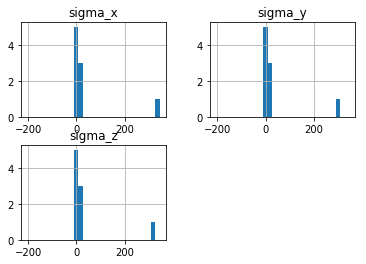

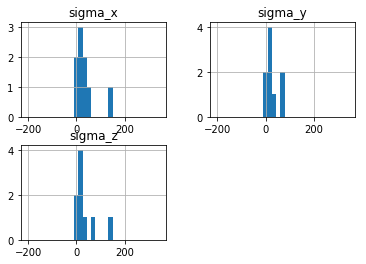

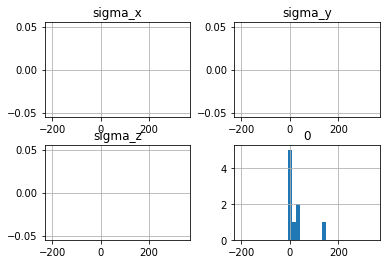

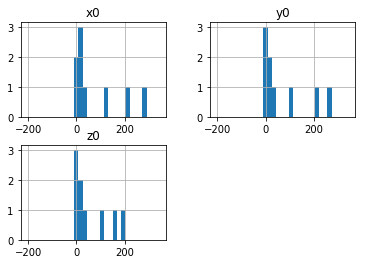

In [25]:
bins = np.linspace(-1, 1, 32) * mu2.std().mean() * 3 + mu2.mean().mean()
s2.sample(n=len(mu2)).hist(bins=bins)
s3.sample(n=len(mu2)).hist(bins=bins)
s4.sample(n=len(mu2)).hist(bins=bins)
mu2.hist(bins=bins)

In [42]:
# new code
def agg_groups(df_grouped):
    """Aggregate groups, weighted mean as usual, and sigmas are standard error on the weighted
    mean as calculated in the reference below.
    
    Gatz, Donald F., and Luther Smith.
    “The Standard Error of a Weighted Mean Concentration—I. Bootstrapping vs Other Methods.”
    Atmospheric Environment 29, no. 11 (June 1, 1995): 1185–93.
    https://doi.org/10.1016/1352-2310(94)00210-C
    """
    coords = ["x", "y", "z"]
    
    # turns out that its fastest to use pandas aggs built in functions at all
    # costs, even more memory, so we need to build the columns we'll use
    # later on
    
    # coordinates
    sigmas = []
    # coordinates
    xi = []
    # weights
    wi = []
    # square weights
    wi2 = []
    # weighted coordinates
    wi_xi = []
    # square weighted coordinates
    wi2_xi = []
    # square weighted squared coordinates
    wi2_xi2 = []
    
    # loop through coords generating weights and weighted coords
    for c in coords:
        s = "sigma_" + c
        sigmas.append(s)
        x = c + "0"
        xi.append(x)
        # calculate weights
        wi.append("wi_" + c)
        df_grouped[wi[-1]] = 1 / df_grouped[s] ** 2
        # square weights
        wi2.append("wi2_" + c)
        df_grouped[wi2[-1]] = 1 / df_grouped[s] ** 4
        # weighted position
        wi_xi.append("wi_xi_" + c)
        df_grouped[wi_xi[-1]] = df_grouped[x].mul(df_grouped[wi[-1]], "index")
        # square weighted coordinates
        wi2_xi.append("wi2_xi_" + c)
        df_grouped[wi2_xi[-1]] = df_grouped[x].mul(df_grouped[wi2[-1]], "index")
        # square weighted squared coordinates
        wi2_xi2.append("wi2_xi2_" + c)
        df_grouped[wi2_xi2[-1]] = (df_grouped[x] ** 2).mul(df_grouped[wi2[-1]], "index")
        
    
    # groupby group_id and sum
    temp_gb = df_grouped.groupby("group_id")
    
    # calc new group params
    new_amp = temp_gb[["amp", "nphotons", "chi2"]].sum()
    new_frame = temp_gb[["frame"]].first()
    groupsize = temp_gb.size()
    groupsize.name = "groupsize"
    
    # calculate sum weights
    wi_bar = temp_gb[wi].sum().values
    
    # finish weighted mean
    mu = temp_gb[wi_xi].sum() / wi_bar
    
    # doing this here to preserve order
    mu.columns = [c[-1] + "0" for c in mu.columns]
    
    # calc new sigma
    new_sigmas = (temp_gb[wi2_xi2].sum().values
                  - 2 * mu[xi] * temp_gb[wi2_xi].sum().values
                  + (mu[xi] ** 2) * temp_gb[wi2].sum().values)
    gsize = groupsize.values[:, None]
    with np.errstate(divide='ignore', invalid='ignore'):
        new_sigmas = np.sqrt((gsize / (gsize - 1)) * new_sigmas / wi_bar ** 2)
    new_sigmas.columns = ["sigma_" + c[0] for c in xi]
    nan_locs = ~np.isfinite(new_sigmas).all(1)
    new_sigmas[nan_locs] = temp_gb[sigmas].first()[nan_locs]
    
    # take the mean of all remaining columns
    # figure out columns to drop
    extra_columns = wi + wi2 + wi_xi + wi2_xi + wi2_xi2
    other_columns = ["groupsize"] + extra_columns
    for df in (mu, new_sigmas, new_amp, new_frame):
        other_columns += df.columns.tolist()
    other_columns += ["group_id"]
    columns_to_mean = df_grouped.columns.difference(other_columns)
    # take the mean
    new_means = temp_gb[columns_to_mean].mean()
    
    # drop added columns from original data frame
    df_grouped.drop(columns=extra_columns, inplace=True)
    
    # return new data frame
    df_agg = pd.concat([mu, new_sigmas, new_amp, new_frame, groupsize, new_means], axis=1)
    return df_agg

In [43]:
%timeit agg_groups(data)
%timeit pdiag.agg_groups(data)

498 ms ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
544 ms ± 26.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
np.allclose(pdiag.agg_groups(data), agg_groups(data))

True

In [45]:
np.allclose(pdiag.agg_groups(data)[sigmas], s2)

True

In [46]:
agg = agg_groups(data)
agg.head()

,x0,y0,z0,sigma_x,sigma_y,sigma_z,amp,nphotons,chi2,frame,groupsize,offset
group_id,,,,,,,,,,,,
-546,36.812747,-323.717347,329.519362,324.876217,282.142304,312.525604,-1.745548,0.220190,1.118870,-0.597209,1,-0.445652
-463,-47.666622,-5.760682,-178.831439,21.968467,34.090580,81.477090,-1.042937,-0.087241,-2.048392,1.706636,2,-0.088703
-449,299.826395,-57.297838,-321.670523,307.951315,354.476403,276.415307,0.431714,-0.824119,0.513141,-1.079956,1,2.001400
-446,228.651787,-478.208150,175.126075,348.729174,267.348999,303.936047,-0.460499,-2.428943,0.585660,-0.779343,1,0.814452
-445,10.093731,-524.150788,92.041369,257.290775,299.101327,307.043601,-0.151634,-1.004684,-2.116836,-0.872124,1,0.946876


In [47]:
np.isfinite(agg).all(1).all()

True

In [48]:
# make sure our new code works
np.allclose(agg_groups(data)[sigmas], s2)

True

sigma_x    2.170890
sigma_y    2.150853
sigma_z    2.166197
dtype: float64
x0    1.984385
y0    2.039222
z0    1.895328
dtype: float64
sigma_x    29.629764
sigma_y    29.635993
sigma_z    29.601937
dtype: float64


x0    29.857581
y0    29.590157
z0    29.492337
dtype: float64

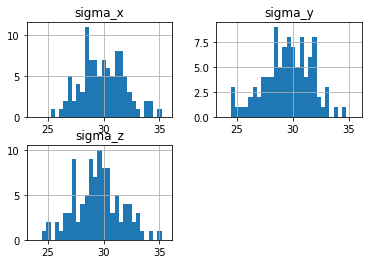

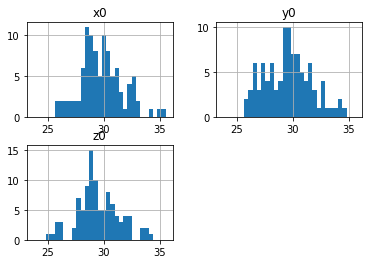

In [33]:
# check that bootstrapped and calculated distributions match
bins = np.linspace(-1, 1, 32) * mu2.std().mean() * 3 + mu2.mean().mean()
agg[sigmas].sample(n=len(mu2)).hist(bins=bins)
mu2.hist(bins=bins)
print(agg[sigmas].std())
print(mu2.std())
print(agg[sigmas].mean())
mu2.mean()

In [ ]:
agg.dropna()